In [1]:
import ratinabox
from ratinabox import Environment, Agent
from ratinabox.Neurons import PlaceCells
import numpy as np
import shapely
import matplotlib.pyplot as plt
import pickle
from artemutils.colormaps import get_colormap

In [2]:
maze_points = [
    (786.73, 1167.85),
    (0, 1167.85),
    (0, 919.05),
    (361.27, 919.05),
    (361.27, 824.44),
    (196.51, 824.44),
    (196.51, 452.58),
    (488.31, 452.58),
    (488.31, 354),
    (0, 354),
    (0, 0),
    (267.32, 0),
    (267.32, 90),
    (90, 90),
    (90, 264),
    (578.31, 264),
    (578.31, 542.58),
    (286.51, 542.58),
    (286.51, 734.44),
    (451.27, 734.44),
    (451.27, 1009.05),
    (90, 1009.05),
    (90, 1077.85),
    (696.73, 1077.85),
    (696.73, 669.62),
    (521.4, 669.62),
    (521.4, 579.62),
    (786.73, 579.62),
    (786.73, 1167.85)
]

trajectory_points = [
    (521.4, 624.62),
    (741.73, 624.62),
    (741.73, 1122.85),
    (45, 1122.85),
    (45, 964.05),
    (406.27, 964.05),
    (406.27, 779.44),
    (241.51, 779.44),
    (241.51, 497.58),
    (533.31, 497.58),
    (533.31, 309),
    (45, 309),
    (45, 45),
    (267.32, 45)
]


maze_points = np.array(maze_points)
trajectory_points = np.array(trajectory_points)

# Normalize coordinates to be within 0-1 and keep aspect ratio
def normalize_points(points):
    points = points - maze_points.min(axis=0)
    points = points / maze_points.max(axis=0)
    points = points * np.array([1, 1.5])
    return points


trajectory_points = normalize_points(trajectory_points)
maze_points = normalize_points(maze_points)


In [3]:
# --- ZigZag track
trajectory = shapely.geometry.LineString(trajectory_points)
def pos_to_maze(alpha, trajectory):
    points = trajectory.interpolate(alpha, normalized=True)
    xs = [p.x for p in points]
    ys = [p.y for p in points]
    return np.stack([xs, ys], axis=1)



Env = Environment(
    params={
        'boundary': maze_points,
    }
)

Ag = Agent(Env)
T = 20
N_points = 1000
times = np.linspace(0, T, 2*N_points)
points = np.concatenate([pos_to_maze(np.linspace(0, 1, N_points), trajectory), pos_to_maze(np.linspace(1, 0, N_points), trajectory)])


Ag.import_trajectory(
    times=times,
    positions=points,
    interpolate=True,
)

# --- Place cells
N_place_cells = 25
centers = pos_to_maze(np.linspace(0, 1, N_place_cells), trajectory)

PCs = PlaceCells(Ag, params={
    'place_cell_centres': centers,
    'max_fr' : 40,
    'widths': 0.02
})

# --- Run the simulation
for i in range(int(T/Ag.dt)): 
    Ag.update()
    PCs.update()
 
cmap = get_colormap('coolors-1')
PCs.colors = cmap(np.linspace(0, 1, N_place_cells))

# with open("ratinabox_output_linear_track_extended.pickle", "wb") as f:
#     pickle.dump({"Environment":Env, "Agent":Ag, 'PlaceCells':PCs}, f)

Successfully imported dataset from arrays passed
Total of 20.0 s of data available
'geodesic' wall geometry only supported for enivironments with 1 additional wall (4 bounding walls + 1 additional). Sorry. Using 'line_of_sight' instead.


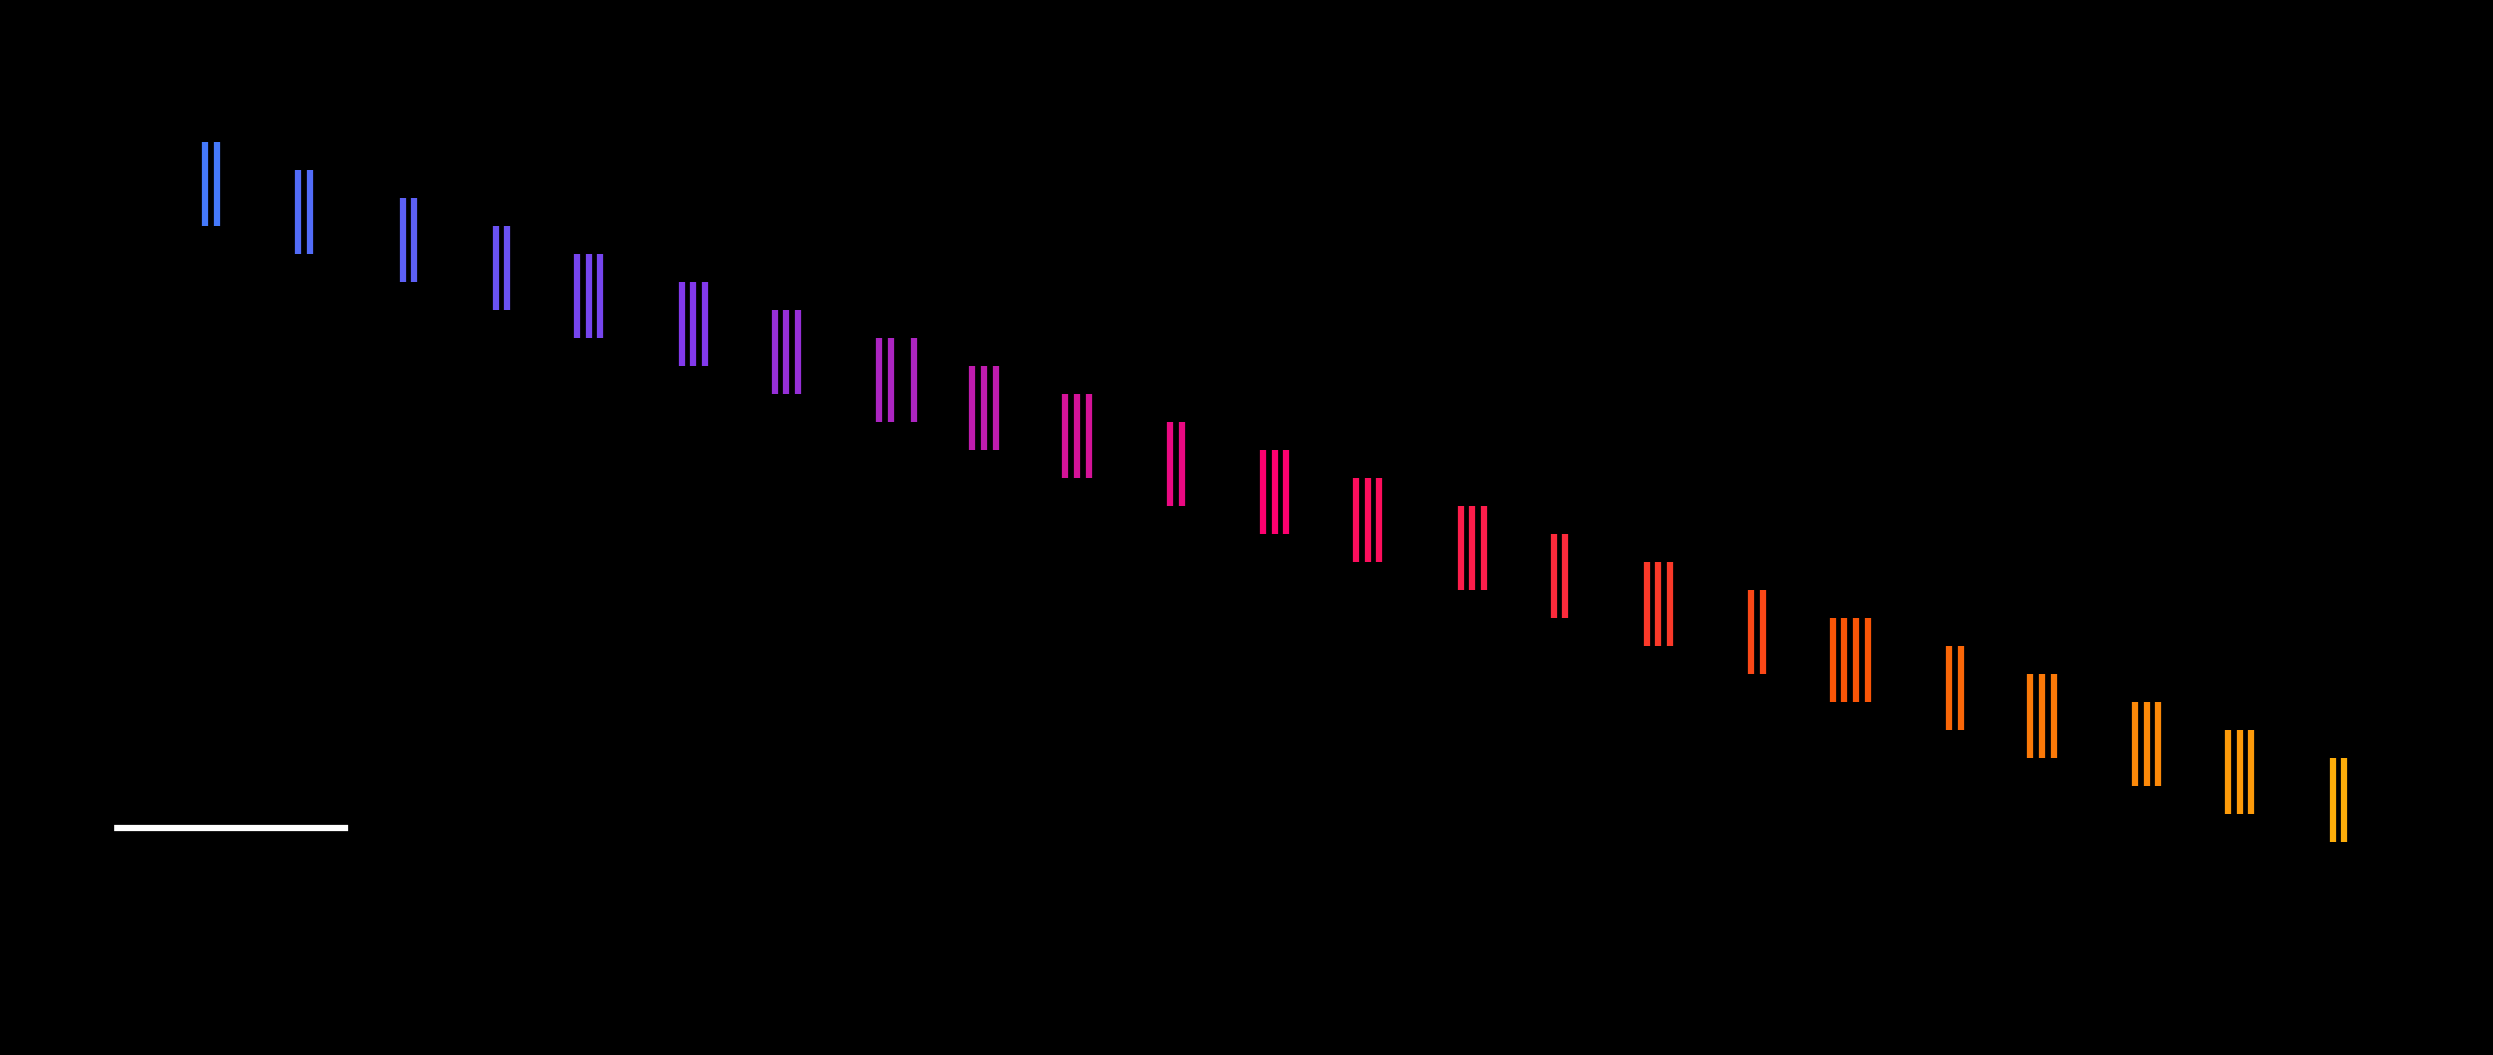

In [35]:
# Getting spike trains

t = PCs.get_history_arrays()['t']
spikes = PCs.get_history_arrays()['spikes']

fig, ax = plt.subplots(1,1,figsize=(10,4), dpi=300)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
ax.eventplot([t[spikes[:, cell_idx]] for cell_idx in range(N_place_cells)][::-1], colors=PCs.colors, linelengths=3)
ax.plot([0,1], [0,0], color='white')
ax.set_xlim(0,T/2)
fig.savefig('behavior_trace.svg')